<a href="https://colab.research.google.com/github/MacjonnyTaiwan/Ameba_Blink/blob/main/supervision_0_24_0_promo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Supervision 0.24.0 promo

### Install dependencies

In [ ]:
!pip install -q ultralytics supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.0/882.0 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 11.1 MB/s eta 0:00:00


In [ ]:
import supervision as sv
print(sv.__version__)

0.24.0


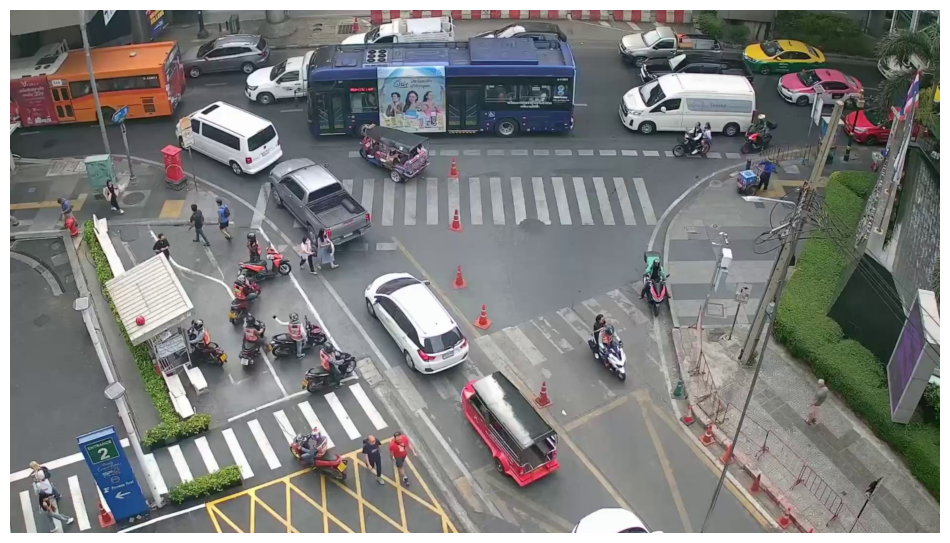

In [ ]:
VIDEO_PATH = "/content/supervision-0.24.0-promo.mp4"

frame_generator = sv.get_video_frames_generator(VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11x.pt")

100%|██████████| 109M/109M [00:01<00:00, 99.5MB/s]


In [ ]:
from tqdm import tqdm

SOURCE_VIDEO_PATH = "/content/supervision-0.24.0-promo.mp4"
TARGET_VIDEO_PATH = "/content/supervision-0.24.0-promo-result.mp4"

LINE_ZONE_ANNOTATOR = sv.LineZoneAnnotator(
    text_scale=0.8,
    text_orient_to_line=True,
    display_text_box=True,
    text_centered=False
)
LINE_ZONE_ANNOTATOR_MULTICLASS = sv.LineZoneAnnotatorMulticlass(
    text_scale=0.8,
    text_thickness=2
)
COLOR_ANNOTATOR = sv.ColorAnnotator()
LABEL_ANNOTATOR = sv.LabelAnnotator(
    text_scale=0.7,
    text_thickness=2,
    text_position=sv.Position.BOTTOM_CENTER
)
TRACK_ANNOTATOR = sv.TraceAnnotator(trace_length=60 * 2)

LINE_1_START = sv.Point(631, 76)
LINE_1_END = sv.Point(450, 378)

LINE_2_START = sv.Point(716, 758)
LINE_2_END = sv.Point(1319, 547)

LINE_3_START = sv.Point(1282, 81)
LINE_3_END = sv.Point(1404, 375)

LINE_ZONE_1 = sv.LineZone(
    start=LINE_1_START,
    end=LINE_1_END,
    triggering_anchors=(sv.Position.BOTTOM_CENTER,)
)

LINE_ZONE_2 = sv.LineZone(
    start=LINE_2_START,
    end=LINE_2_END,
    triggering_anchors=(sv.Position.BOTTOM_CENTER,)
)

LINE_ZONE_3 = sv.LineZone(
    start=LINE_3_START,
    end=LINE_3_END,
    triggering_anchors=(sv.Position.BOTTOM_CENTER,)
)

TRACKER = sv.ByteTrack(minimum_consecutive_frames=5)
TRACKER.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=60 * 15, end=60 * 30)
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)

with video_sink:
    for frame_idx, frame in tqdm(enumerate(frame_generator)):

        result = model(frame, conf=0.35, imgsz=1280, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)
        detections = detections[detections.class_id != 0]
        detections = TRACKER.update_with_detections(detections)

        LINE_ZONE_1.trigger(detections)
        LINE_ZONE_2.trigger(detections)
        LINE_ZONE_3.trigger(detections)

        annotated_frame = frame.copy()
        annotated_frame = COLOR_ANNOTATOR.annotate(annotated_frame, detections)
        annotated_frame = LABEL_ANNOTATOR.annotate(annotated_frame, detections)
        annotated_frame = TRACK_ANNOTATOR.annotate(annotated_frame, detections)
        annotated_frame = LINE_ZONE_ANNOTATOR.annotate(
            frame=annotated_frame, line_counter=LINE_ZONE_1
        )
        annotated_frame = LINE_ZONE_ANNOTATOR.annotate(
            frame=annotated_frame, line_counter=LINE_ZONE_2
        )
        annotated_frame = LINE_ZONE_ANNOTATOR.annotate(
            frame=annotated_frame, line_counter=LINE_ZONE_3
        )
        annotated_frame = LINE_ZONE_ANNOTATOR_MULTICLASS.annotate(
            frame=annotated_frame, line_zones=[LINE_ZONE_1, LINE_ZONE_2, LINE_ZONE_3]
        )

        video_sink.write_frame(annotated_frame)

900it [02:40,  5.62it/s]
